In [1]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

c:\program files\python35\lib\site-packages\scipy\stats\morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
c:\program files\python35\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\program files\python35\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейки нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

In [5]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def clean(words):
    clean = [morph.parse(word)[0].normal_form for word in words if word.isalnum()]
    return clean

def preprocess(text_words):
    return [i for i in text_words if i!="lt" and i!="gt" and i not in stopwords.words('english') and i not in stopwords.words('russian')]

In [7]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

### 4.1) Загрузим хороший словарь

In [8]:
# batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',  # название файла
#                                         data_format='vowpal_wabbit', # формат файла, у нас vw
#                                         target_folder='batches', # название папки в которую положаться батчи
#                                         batch_size=1000) # размер батча, подбирайте под свою память

In [10]:
# batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
#                                         data_format='batches') # указываем формат - батчи

In [9]:
# dictionary = artm.Dictionary()

In [11]:
# dictionary.gather(data_path='batches')
# dictionary.filter(class_id='@default_class',
#                   min_df=30, max_df=200)

In [12]:
# dictionary.save_text('dict.txt')

In [28]:
dictionary = artm.Dictionary()
dictionary.load_text('dict.txt')

### 5) Позапускаем модель

In [55]:
model = artm.ARTM(num_topics=50, dictionary=dictionary)

In [56]:
scores = [
    artm.PerplexityScore(name='perp_score', dictionary=dictionary),
    artm.SparsityPhiScore(name='phi_sparsity_score'),    
    artm.SparsityThetaScore(name='theta_sparsity_score'),
    artm.TopTokensScore(name='top_tokens_score')    
]

for score in scores:
    model.scores.add(score)

In [57]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [58]:
def plot_scores(model):
    plt.plot(model.score_tracker['perp_score'].value[1:])
    plt.title('Perplexity score')
    plt.xlabel('Iteration')
    plt.ylabel('Perplexity')
    plt.show()
    
    plt.plot(model.score_tracker['theta_sparsity_score'].value[1:])
    plt.title('Theta Sparsity score')
    plt.xlabel('Iteration')
    plt.ylabel('Theta Sparsity')
    plt.show()
    
    plt.plot(model.score_tracker['phi_sparsity_score'].value[1:])
    plt.title('Phi Sparsity score')
    plt.xlabel('Iteration')
    plt.ylabel('Phi Sparsity')
    plt.show()
    
    saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens

    for topic_name in model.topic_names:
        print(', '.join(saved_top_tokens[topic_name]))

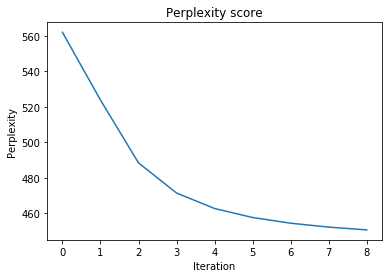

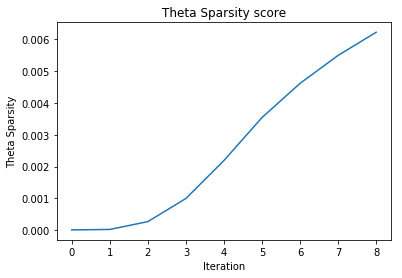

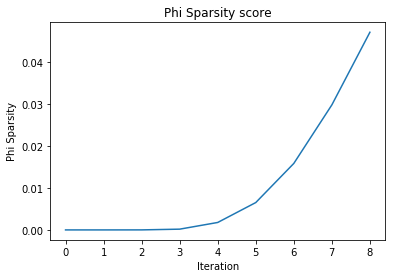

скидка, хостинг, акция, накопитель, ssd, oracle, виртуализация, vps, пятница, ram
amazon, рекламный, кандидат, андрей, соревнование, голос, александр, handle, кампания, состояться
дисплей, ноутбук, видеокарта, пиксель, клавиатура, линейка, hd, nvidia, гб, lenovo
vr, персонаж, враг, жанр, фигура, герой, сцена, бой, геймплей, студия
регистр, анализатор, битый, байт, указатель, луч, foo, компилятор, видимость, импульс
звонок, предприятие, azure, абонент, business, sip, skype, телефонный, техподдержка, заявка
блокировка, усилитель, рейтинг, искажение, tcp, заблокировать, коэффициент, усиление, блокировать, аномалия
планирование, студент, инвестор, scrum, школа, тз, исполнитель, занятие, инвестиция, заявка
char, input, unsigned, блокчейн, транзакция, bitcoin, криптовалюта, валюта, buffer, нативный
research, swift, div, international, science, width, props, height, color, world
вакансия, зарплата, образование, linkedin, математика, зарубежный, поисковый, работодатель, кандидат, отечественный

In [59]:
plot_scores(model)

In [60]:
regularizers = [
    artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_words'),
    artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer_words'),
    artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer')
]

for regularizer in regularizers:
    model.regularizers.add(regularizer)

In [61]:
model.regularizers['decorrelator_phi_words'].tau = 1e+5
model.regularizers['sparse_phi_regularizer_words'].tau = -1.0
model.regularizers['sparse_theta_regularizer'].tau = -2.5

In [62]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

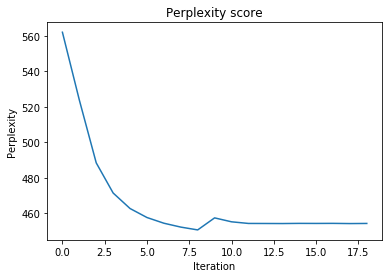

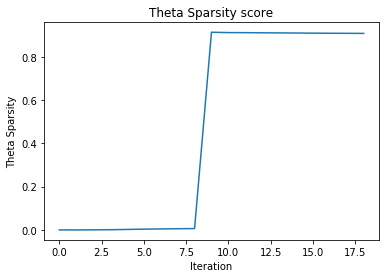

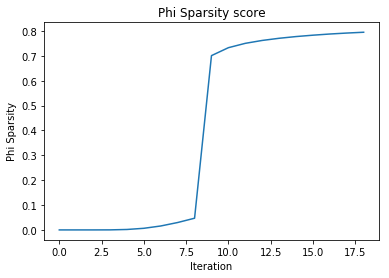

скидка, хостинг, накопитель, ssd, ibm, oracle, виртуализация, акция, цод, vps
соревнование, кандидат, спикер, amazon, выступление, конкурс, андрей, александр, голос, победитель
дисплей, ноутбук, гб, видеокарта, клавиатура, usb, hd, nvidia, lenovo, линейка
vr, персонаж, сцена, враг, жанр, герой, очки, фигура, геймплей, game
регистр, битый, анализатор, байт, указатель, компилятор, foo, f, предупреждение, плавать
звонок, заявка, абонент, предприятие, azure, sip, договор, sla, сотовый, skype
блокировка, усилитель, искажение, звуковой, tcp, рейтинг, усиление, шум, коэффициент, воспроизведение
планирование, инвестор, scrum, тз, дизайнер, школа, ит, исполнитель, спринт, студент
char, блокчейн, unsigned, input, bitcoin, криптовалюта, транзакция, buffer, output, валюта
div, swift, research, props, width, international, li, height, h1, button
вакансия, зарплата, образование, linkedin, математика, зарубежный, работодатель, кандидат, собеседование, профессия
координата, матрица, вектор, float, сет

In [63]:
plot_scores(model)

Попробуем снова модель без начальных регуляризаторов, но потом их понастраивать

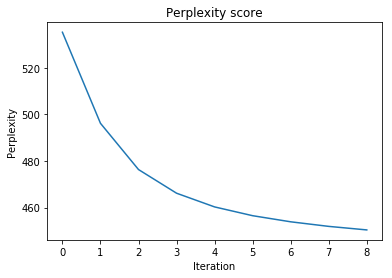

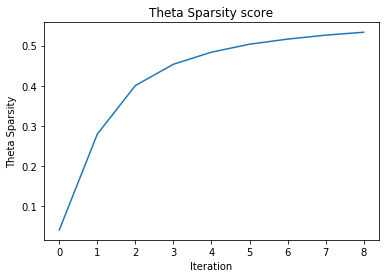

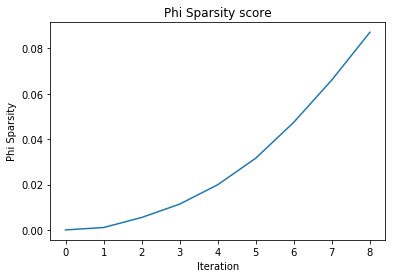

скидка, хостинг, акция, ssd, oracle, виртуализация, тариф, накопитель, vps, ram
выступление, кандидат, андрей, александр, спикер, соревнование, сергей, голос, состояться, организатор
ноутбук, дисплей, гб, пиксель, видеокарта, линейка, hd, lenovo, клавиатура, pro
vr, персонаж, сцена, враг, жанр, фигура, очки, герой, геймплей, студия
байт, регистр, компилятор, битый, указатель, f, буфер, ассемблер, foo, видимость
звонок, предприятие, azure, абонент, sip, skype, телефонный, business, портал, edge
блокировка, усилитель, напряжение, искажение, битый, атрибут, рейтинг, коэффициент, усиление, подсеть
студент, планирование, школа, scrum, образование, занятие, профессия, ит, исполнитель, мотивация
input, блокчейн, swift, unsigned, char, транзакция, bitcoin, криптовалюта, валюта, 61
research, international, science, width, height, color, css, h1, парсер, ширина
вакансия, long, linkedin, кандидат, зарубежный, работодатель, зарплата, лекция, отечественный, резюме
координата, вектор, матрица, сетка

In [64]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)])
scores = [
    artm.PerplexityScore(name='perp_score', dictionary=dictionary),
    artm.SparsityPhiScore(name='phi_sparsity_score'),    
    artm.SparsityThetaScore(name='theta_sparsity_score'),
    artm.TopTokensScore(name='top_tokens_score')    
]
for score in scores:
    model_artm.scores.add(score)
model_artm.initialize(dictionary=dictionary)
model_artm.num_document_passes = 50
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
plot_scores(model_artm)

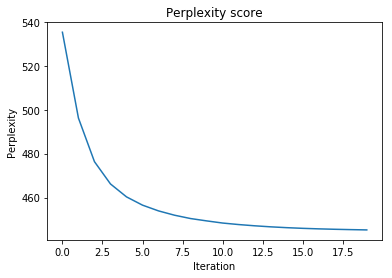

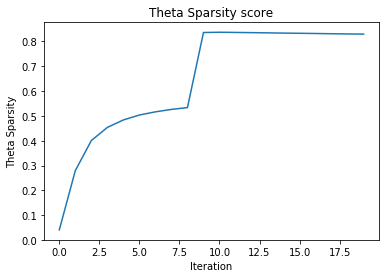

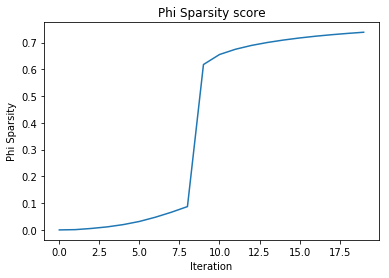

скидка, хостинг, накопитель, ssd, oracle, акция, цод, виртуализация, vps, тариф
выступление, соревнование, александр, кандидат, андрей, спикер, конкурс, сергей, московский, заявка
ноутбук, дисплей, гб, клавиатура, видеокарта, pro, lenovo, hd, линейка, монитор
vr, персонаж, сцена, враг, жанр, очки, фигура, герой, game, сюжет
компилятор, регистр, байт, указатель, битый, буфер, ассемблер, foo, стек, f
звонок, предприятие, абонент, azure, телефонный, business, sip, skype, портал, devops
напряжение, ток, усилитель, импульс, блокировка, звуковой, битый, генератор, искажение, транзистор
планирование, студент, scrum, школа, образование, профессия, ит, исполнитель, ученик, занятие
input, блокчейн, swift, unsigned, транзакция, char, bitcoin, криптовалюта, валюта, output
research, div, international, width, science, height, css, ширина, парсер, button
вакансия, лекция, зарплата, long, linkedin, кандидат, работодатель, математика, зарубежный, e
координата, матрица, вектор, float, сетка, пиксель, z

In [65]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 50)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 50)]))
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
# будем постепенно увеличивать значения этих регуляризаторов
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau
for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
plot_scores(model_artm)

#### Видно, что эта модель гораздо лучше предыдущей, в ней более точные ключевые слова для топиков

"Базы данных" и "Чат-боты":

##### было

select, sql, array, table, varchar, go, count, item, default, create

бот, crm, чат, telegram, 1с, мессенджер, cms, карточка, админ, опрос

##### стало

select, go, sql, table, varchar, индекс, add, бд, count, default

бот, чат, crm, telegram, сертификат, мессенджер, заметка, админ, заявка, трансляция

Давайте попробуем сразу добавить регуляризаторы:

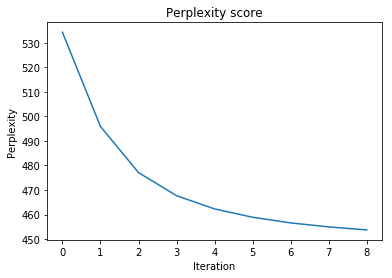

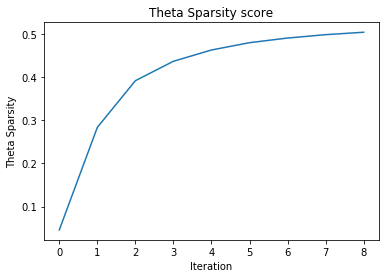

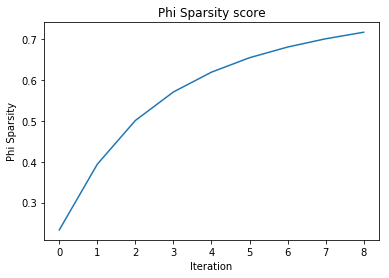

скидка, хостинг, акция, ssd, тариф, виртуализация, oracle, vps, ram, пятница
выступление, александр, кандидат, андрей, спикер, сергей, голос, соревнование, состояться, московский
дисплей, ноутбук, гб, пиксель, видеокарта, линейка, hd, lenovo, монитор, ггц
vr, персонаж, сцена, враг, очки, жанр, фигура, студия, герой, геймплей
байт, регистр, компилятор, указатель, битый, f, буфер, foo, ассемблер, видимость
звонок, предприятие, azure, абонент, sip, портал, edge, business, телефонный, skype
блокировка, усилитель, напряжение, битый, искажение, атрибут, коэффициент, рейтинг, усиление, заблокировать
студент, планирование, scrum, школа, ит, образование, мотивация, занятие, интервью, uber
input, блокчейн, unsigned, swift, char, транзакция, bitcoin, криптовалюта, output, валюта
research, science, international, width, height, color, h1, парсер, css, ширина
вакансия, long, лекция, linkedin, кандидат, зарубежный, работодатель, зарплата, образование, математика
координата, вектор, матрица, сетка, z

In [68]:
model_ = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(50)],
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.15, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=-0.15, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 50)])
                                    ]
                        )

scores = [
    artm.PerplexityScore(name='perp_score', dictionary=dictionary),
    artm.SparsityPhiScore(name='phi_sparsity_score'),    
    artm.SparsityThetaScore(name='theta_sparsity_score'),
    artm.TopTokensScore(name='top_tokens_score')    
]
for score in scores:
    model_.scores.add(score)
model_.initialize(dictionary=dictionary)
model_.num_document_passes = 50
model_.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
plot_scores(model_)


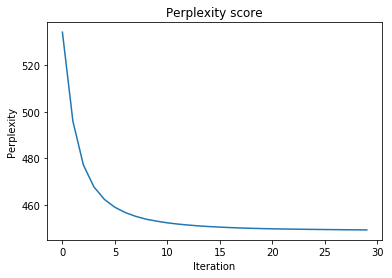

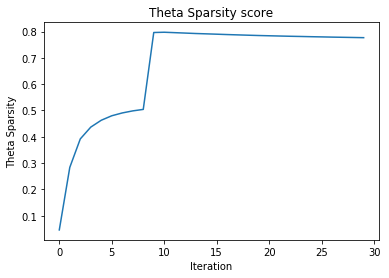

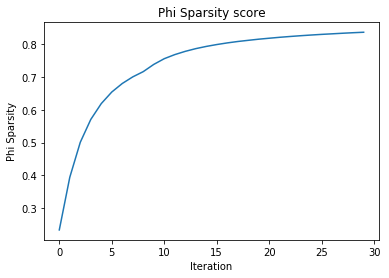

скидка, хостинг, накопитель, ssd, ibm, oracle, акция, виртуализация, тариф, vps
выступление, александр, соревнование, кандидат, андрей, спикер, сергей, студент, московский, зал
ноутбук, дисплей, гб, клавиатура, видеокарта, pro, линейка, lenovo, nvidia, hd
vr, персонаж, сцена, очки, враг, жанр, фигура, бой, герой, game
компилятор, регистр, байт, указатель, битый, буфер, ассемблер, стек, foo, компиляция
звонок, заявка, предприятие, azure, абонент, поставщик, телефонный, sip, техподдержка, business
напряжение, ток, усилитель, звуковой, генератор, импульс, битый, искажение, транзистор, коэффициент
планирование, студент, ит, scrum, школа, мотивация, профессия, спринт, исполнитель, занятие
input, блокчейн, swift, unsigned, char, транзакция, 31, bitcoin, криптовалюта, output
research, div, international, width, science, height, css, h1, парсер, тег
вакансия, лекция, математика, зарплата, linkedin, математический, образование, кандидат, работодатель, собеседование
координата, вектор, матрица, 

In [69]:
regularizers = [
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.15,topic_names=['topic_{}'.format(i) for i in range(1, 50)]),
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15, topic_names=['topic_{}'.format(i) for i in range(1, 50)])
]
for regularizer in regularizers:
    model_.regularizers.add(regularizer)
model_.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
phi_tau = model_.regularizers['SparsePhi'].tau
theta_tau = model_.regularizers['SparseTheta'].tau
for i in range(10):
    model_.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=2)
plot_scores(model_)

### 6) Top-6 лучших тем:

1) ия, нейронный, интеллект, нейросеть, анализатор, нейрон, распознавание, обучать, сознание, классификация

2) js, css, angular, chrome, слушать, react, ruby, фреймворк, firefox, веб

3) печать, принтер, 3d, gpu, маска, бумага, печатать, сканер, сессия, пластик

4) маршрут, метка, шлюз, маршрутизатор, cisco, коммутатор, iot, show, маршрутизация, route

Особенно забавно распределяются эти темы:

5) солнечный, планета, звезда, солнце, астероид, атмосфера, орбита, прибор, телескоп, небо

6) вселенная, квантовый, галактика, частица, тёмный, излучение, атом, физика, фотон, материя

### 7) Графики обучения этой модели расположены выше, перплексия, как и должно быть, снижается и находится как раз в пределах 200-1000 (менее 460),  фи и тета стремятся к 1. 

### 8) Параметры
Количество тем: 50

Регуляризаторы: DecorrelatorPhiRegularizer (tau=0.15), SmoothSparsePhiRegularizer (tau=-0.15)

num_document_passes = 50

num_collection_passes=10

Потом добавили регуляризаторы SmoothSparsePhiRegularizer (tau=-0.15), SmoothSparseThetaRegularizer (tau=-0.15)

Затем для 10 итераций при num_collection_passes=2 увеличивали SparsePhi на phi_tau + (phi_tau\*0.5) и SparseTheta на theta_tau + (theta_tau\*0.1)

Перплексия снижалась, тау и фи росли (особенно после добавления регуляризаторов (~ 8 итерация на графике)). Все более чем замечательно

#### Попробуем иерархическую модель? Без подбора параметров, просто посмотреть, как это работает

In [106]:
regularizers = [
    artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_words'),
    artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer_words'),
    artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer')
]

hier = artm.hARTM(cache_theta=True,
                  reuse_theta=True,  
                  seed=42, 
                  scores=scores,
                  regularizers=regularizers)
level0 = hier.add_level(num_topics=30)
level0.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20, 
                                      class_id='text'))
level0.initialize(dictionary)

level0.regularizers['decorrelator_phi_words'].tau = 1e+5
level0.regularizers['sparse_phi_regularizer_words'].tau = -1.0
level0.regularizers['sparse_theta_regularizer'].tau = -2.5
%time level0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

Wall time: 43.3 s


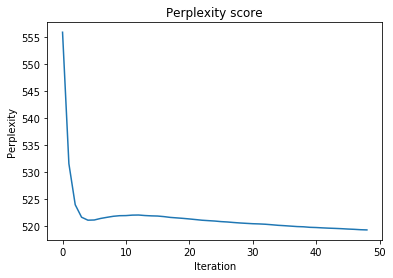

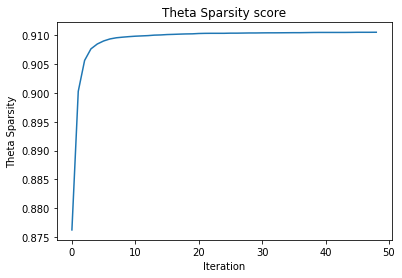

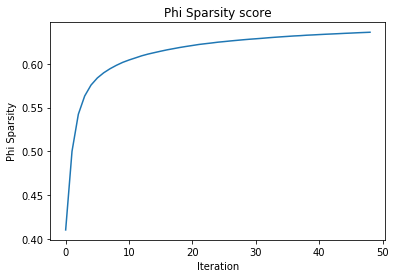

скидка, аккумулятор, мм, гб, ноутбук, xiaomi, хостинг, зарядка, робот, акция
amazon, бренд, кандидат, уязвимость, лекция, форум, php, спутник, рекламный, слушать
дисплей, видеокарта, пиксель, ноутбук, fps, чип, гб, nvidia, 3d, приёмник
research, vr, персонаж, international, science, комната, case, текстура, враг, фигура
робот, пациент, боль, def, вселенная, галактика, частица, врач, бактерия, ibm
резервный, хостинг, заявка, begin, мотор, предприятие, звонок, ibm, support, соревнование
квантовый, напряжение, усилитель, ток, искажение, битый, рейтинг, подсеть, кабель, утечка
scrum, бот, планирование, студент, тз, инвестор, ступень, доход, заявка, образование
char, unsigned, import, e, блокчейн, print, input, sudo, bitcoin, url
float, const, swift, let, пиксель, object, width, div, h1, height
ия, long, блокировка, p, j, математика, linkedin, робот, e, параллельный
матрица, сертификат, маршрут, add, наушник, вектор, метка, сетка, координата, route
val, луна, полёт, ассемблер, компилятор, g

In [107]:
plot_scores(level0)

In [108]:
level1 = hier.add_level(
    num_topics=50,
    topic_names=['child_topic_' + str(i) for i in range(50)],
    parent_level_weight=1
)
level1.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=20, 
                                      class_id='text'))
level1.initialize(dictionary=dictionary)

level1.regularizers['decorrelator_phi_words'].tau = 1e+5
level1.regularizers['sparse_phi_regularizer_words'].tau = -1.0
level1.regularizers['sparse_theta_regularizer'].tau = -2.5

level1.regularizers.add(artm.HierarchySparsingThetaRegularizer(name="HierSp", tau=2),overwrite=True)

%time level1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

Wall time: 1min 34s


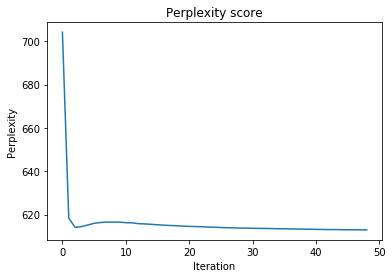

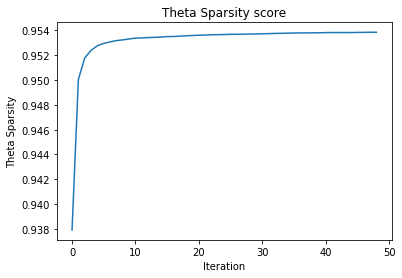

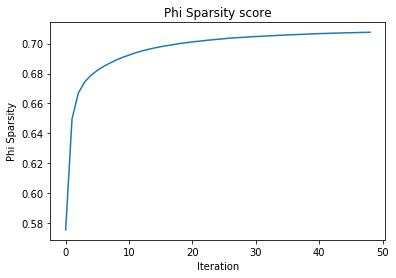

скидка, мм, аккумулятор, ноутбук, гб, xiaomi, хостинг, зарядка, акция, usb
amazon, кандидат, бренд, уязвимость, голос, лекция, рекламный, потребитель, спикер, голосовой
дисплей, видеокарта, ноутбук, пиксель, fps, nvidia, чип, гб, hd, lenovo
research, vr, персонаж, international, science, комната, текстура, case, враг, фигура
пациент, робот, боль, вселенная, def, частица, врач, лечение, галактика, ibm
резервный, хостинг, заявка, begin, мотор, support, звонок, соревнование, предприятие, counter
напряжение, квантовый, усилитель, искажение, ток, рейтинг, битый, подсеть, маска, батарея
scrum, тз, студент, инвестор, бот, планирование, образование, заявка, доход, контракт
char, unsigned, e, блокчейн, import, print, input, bitcoin, нативный, url
const, swift, float, пиксель, let, h1, div, width, height, css
ия, long, блокировка, j, p, математика, e, параллельный, linkedin, работодатель
матрица, сертификат, add, наушник, вектор, сетка, маршрут, координата, метка, hex
луна, полёт, go, компилятор

In [109]:
plot_scores(level1)

In [110]:
get_psi(level1, level0, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 10, 18,  7,  0,
        8, 29, 12, 27,  6,  0, 19, 14,  3,  3, 20,  0, 28, 13, 29,  0],
      dtype=int64)

In [111]:
print_hierarchy_topics(level1, level0, get_psi(level1, level0, 1))

topic_0:
скидка аккумулятор мм гб ноутбук xiaomi хостинг зарядка робот акция

Child topics
    child_topic_0: 
скидка мм аккумулятор ноутбук гб xiaomi хостинг зарядка акция usb
    child_topic_33: 
проектор станок двигатель вакуум вакуумный вечный стойка оповещение платёж металл
    child_topic_39: 
робот аккумулятор телескоп металл антенна зеркало металлический батарейка 5000 мм
    child_topic_45: 
гб маркетинг сканер отпечаток xiaomi видеокарта подписка видеонаблюдение мп amd
    child_topic_49: 
sudo university мастер wifi self make балансировка install агент ubuntu


topic_1:
amazon бренд кандидат уязвимость лекция форум php спутник рекламный слушать

Child topics
    child_topic_1: 
amazon кандидат бренд уязвимость голос лекция рекламный потребитель спикер голосовой


topic_2:
дисплей видеокарта пиксель ноутбук fps чип гб nvidia 3d приёмник

Child topics
    child_topic_2: 
дисплей видеокарта ноутбук пиксель fps nvidia чип гб hd lenovo


topic_3:
research vr персонаж internationa

In [84]:
def print_hierarchy_topics(model, parent_model, indexes_child):
    for i, topic_parent_name in enumerate(parent_model.topic_names):
        print(topic_parent_name + ':')
        print(" ".join(parent_model.score_tracker['top_tokens_score'].last_tokens[topic_parent_name]))
        
        print()
        print('Child topics')

        for child in np.where(indexes_child == i)[0]:
            print('    ' + model.topic_names[child] + ': ')
            print(" ".join(model.score_tracker['top_tokens_score'].last_tokens[model.topic_names[child]]))
        print()
        print()

In [100]:
def get_psi(model, parent_model, level_idx):
    psi = model.get_psi()
    batch = artm.messages.Batch()
    batch_name = 'phi{level_idx}.batch'.format(level_idx=level_idx)

    with open(batch_name, "rb") as f:
        batch.ParseFromString(f.read())

    Ntw = np.zeros(len(parent_model.topic_names))

    for i,item in enumerate(batch.item):
        for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
            Ntw[i] += token_weight

    Nt1t0 = np.array(psi) * Ntw
    psi_bayes = (Nt1t0 / Nt1t0.sum(axis=1)[:, np.newaxis]).T
    indexes_child = np.argmax(psi_bayes, axis=0)
    return indexes_child

Получилась какая-то странная вещь, но зато получилось просто "попробовать и позапускать" иерархическую модель, а подбирать параметры и регуляризаторы -- это to be continued...)